In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from scipy.fft import fft, fftfreq
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential, Model

In [2]:
Input_path = 'D:/Project/AI_ML_Projects/EMG Classification/dataset/EMG-data.csv'
df = pd.read_csv(Input_path)
print(df.head())
print(df.shape)

   time  channel1  channel2  channel3  channel4  channel5  channel6  channel7  \
0     1   0.00001  -0.00002  -0.00001  -0.00003   0.00000  -0.00001   0.00000   
1     5   0.00001  -0.00002  -0.00001  -0.00003   0.00000  -0.00001   0.00000   
2     6  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   
3     7  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   
4     8  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   

   channel8  class  label  
0  -0.00001      0      1  
1  -0.00001      0      1  
2   0.00001      0      1  
3   0.00001      0      1  
4   0.00001      0      1  
(4237907, 11)


In [3]:
print("class :", df["class"].unique())
print()
print("Labels :",df["label"].unique()) # 36 people hand gesture data
print()
print("Value Count :\n",df["class"].value_counts())

class : [0 1 2 3 4 5 6 7]

Labels : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36]

Value Count :
 class
0    2725157
6     253009
5     251733
4     251570
1     250055
3     249494
2     243193
7      13696
Name: count, dtype: int64


In [4]:
features = df.drop(columns=["label","class","time"])
display(features.head())

,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8
0,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001
1,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001
2,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001
3,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001
4,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001


In [5]:
class_labels = {
        1: "Hand at Rest",
        2: "Hand Clenched in a Fist", 
        3: "Wrist Flexion",
        4: "Wrist Extension",
        5: "Radial Deviations",
        6: "Ulnar Deviations",
        7: "Extended Palm"
    }

In [6]:
y = df["class"]
y=y.astype('category')
print(y.info())
print(y)

<class 'pandas.core.series.Series'>
RangeIndex: 4237907 entries, 0 to 4237906
Series name: class
Non-Null Count    Dtype   
--------------    -----   
4237907 non-null  category
dtypes: category(1)
memory usage: 4.0 MB
None
0          0
1          0
2          0
3          0
4          0
          ..
4237902    0
4237903    0
4237904    0
4237905    0
4237906    0
Name: class, Length: 4237907, dtype: category
Categories (8, int64): [0, 1, 2, 3, 4, 5, 6, 7]


In [7]:
df.drop(df[df['class'] == 0].index, inplace=True)

In [8]:

def emg_features(segment):
    x = segment.values  # Pandas Series -> NumPy array
    N = len(x)

    rms = np.sqrt(np.mean(x**2))
    mav = np.mean(np.abs(x))
    wl = np.sum(np.abs(np.diff(x)))
    threshold = 1e-3
    zc = np.sum(((x[:-1] * x[1:]) < 0) & (np.abs(x[:-1] - x[1:]) > threshold))
    ssc = np.sum(((np.diff(x[:-1]) * np.diff(x[1:])) < 0))
    var = np.var(x)

    return np.array([rms, mav, wl, zc, ssc, var])


window_size = 100
step_size = 100
features = []


for start in range(0, len(df) - window_size + 1, step_size):
    window = df.iloc[start:start + window_size]
    row = {}

    for ch in ['channel1', 'channel2', 'channel3', 'channel4',
               'channel5', 'channel6', 'channel7', 'channel8']:
        
        signal = window[ch]
        rms, mav, wl, zc, ssc, var = emg_features(signal)

        row[f'{ch}_rms'] = rms
        row[f'{ch}_mav'] = mav
        row[f'{ch}_wl'] = wl
        row[f'{ch}_zc'] = zc
        row[f'{ch}_ssc'] = ssc
        row[f'{ch}_var'] = var

    
    row['class'] = window['class'].mode()[0]

    features.append(row)


df_features = pd.DataFrame(features)
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15127 entries, 0 to 15126
Data columns (total 49 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   channel1_rms  15127 non-null  float64
 1   channel1_mav  15127 non-null  float64
 2   channel1_wl   15127 non-null  float64
 3   channel1_zc   15127 non-null  float64
 4   channel1_ssc  15127 non-null  float64
 5   channel1_var  15127 non-null  float64
 6   channel2_rms  15127 non-null  float64
 7   channel2_mav  15127 non-null  float64
 8   channel2_wl   15127 non-null  float64
 9   channel2_zc   15127 non-null  float64
 10  channel2_ssc  15127 non-null  float64
 11  channel2_var  15127 non-null  float64
 12  channel3_rms  15127 non-null  float64
 13  channel3_mav  15127 non-null  float64
 14  channel3_wl   15127 non-null  float64
 15  channel3_zc   15127 non-null  float64
 16  channel3_ssc  15127 non-null  float64
 17  channel3_var  15127 non-null  float64
 18  channel4_rms  15127 non-nu

In [9]:
y = df_features["class"]
print(y.unique())
print(y)

[1 2 3 4 5 6 7]
0        1
1        1
2        1
3        1
4        1
        ..
15122    6
15123    6
15124    6
15125    6
15126    6
Name: class, Length: 15127, dtype: int64


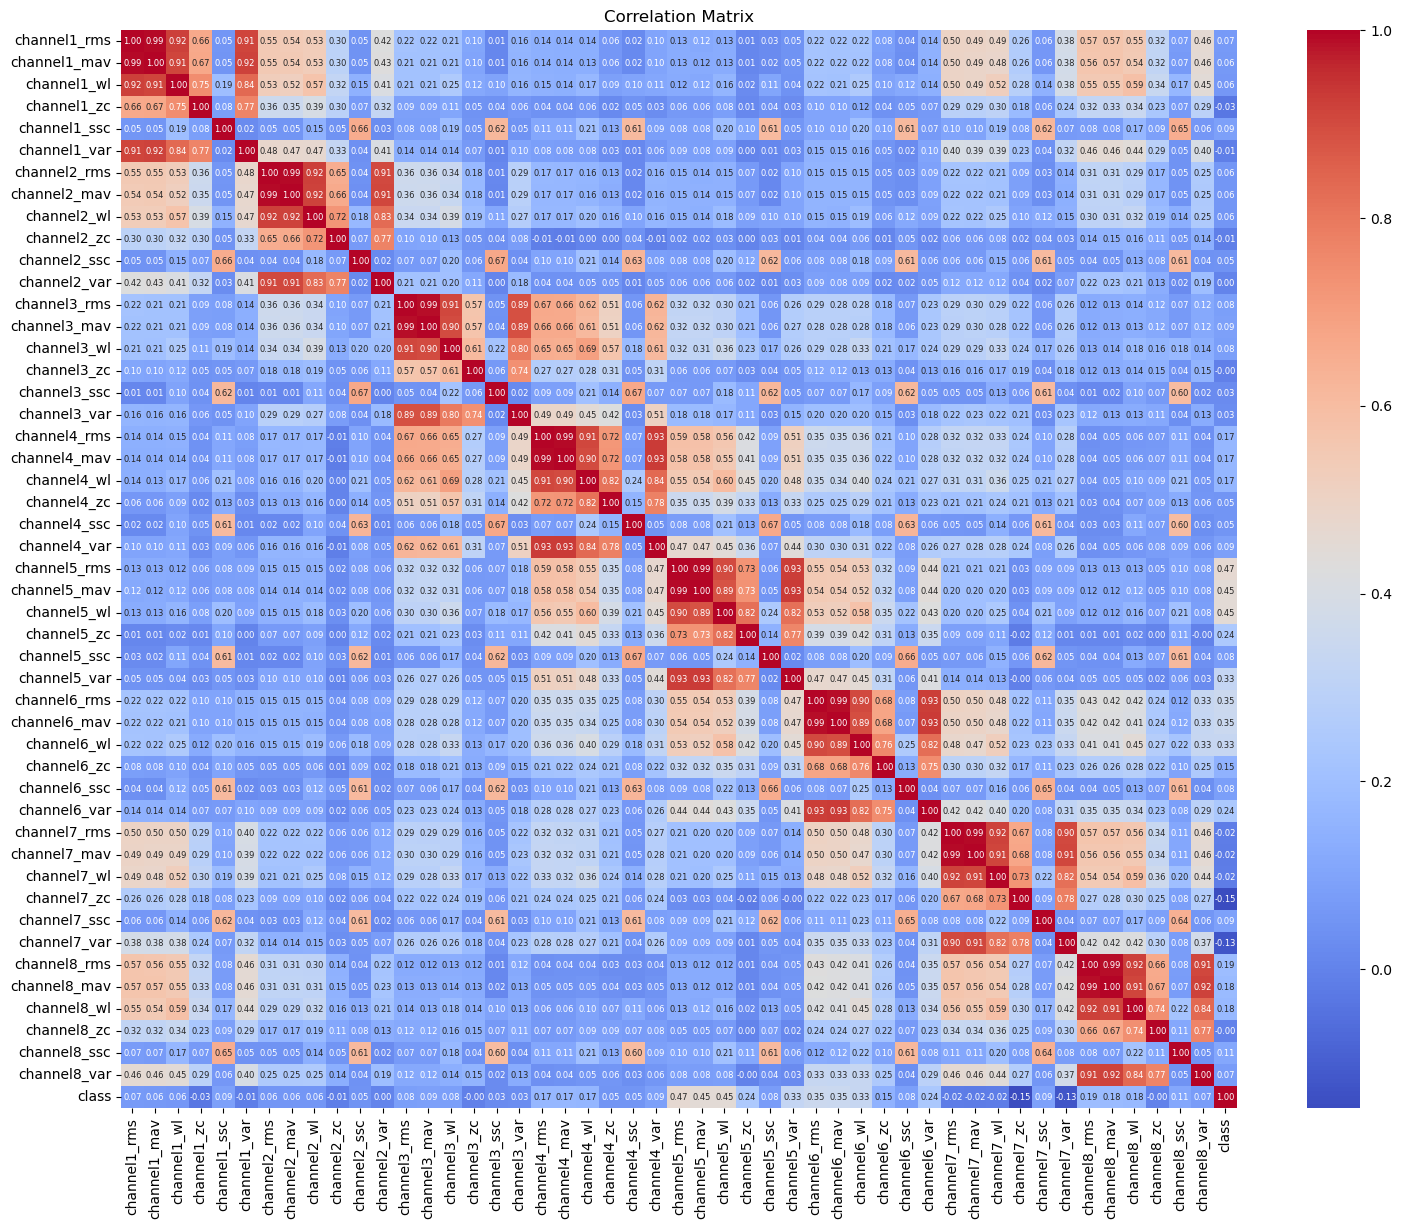

In [10]:

plt.figure(figsize=(18, 14))
sns.heatmap(df_features.corr(), annot=True, cmap='coolwarm',annot_kws={"size": 6}, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

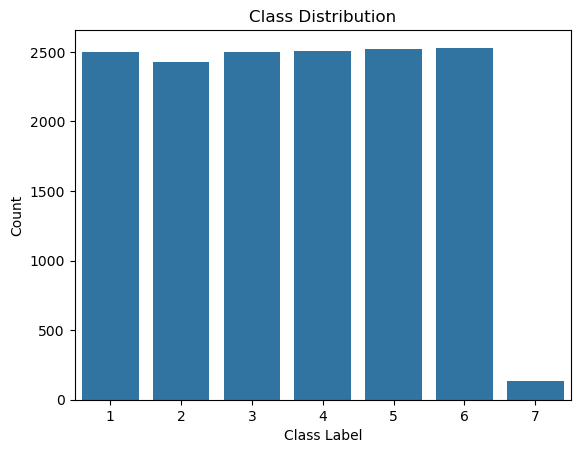

In [11]:
sns.countplot(data=df_features, x='class')
plt.title("Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.show()

In [12]:
df_class7 = df_features[df_features['class'] == 7]
df_others = df_features[df_features['class'] != 7]


df_class7_upsampled = resample(
    df_class7,
    replace=True,
    n_samples=2500,  # target sample value
    random_state=42
)

# Merge all data
df_balanced = pd.concat([df_others, df_class7_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)  
X_resampled = df_balanced.drop(columns=['class'])
y_balanced = df_balanced['class']


num_classes = y_balanced.nunique()
num_classes = y_balanced.max() + 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

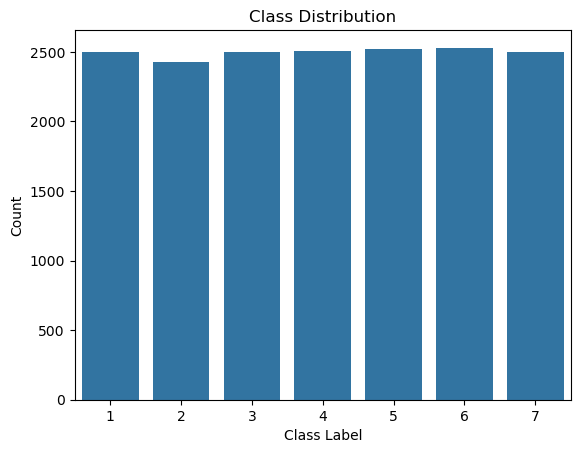

In [13]:
sns.countplot(x = y_balanced)
plt.title("Class Distribution")


plt.xlabel("Class Label")
plt.ylabel("Count")
plt.show()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_balanced, test_size=0.2, random_state=42)

In [15]:
early_stop = EarlyStopping(
    monitor='val_loss',     
    patience=5,             
    restore_best_weights=True 
)

y_train_cat = to_categorical(y_train, num_classes)
y_test_cat  = to_categorical(y_test,  num_classes)


In [16]:
nn_model = Sequential()
nn_model.add(Input(shape=(X_train.shape[1],)))
nn_model.add(Dense(256, activation='relu'))
nn_model.add(BatchNormalization())
nn_model.add(Dropout(0.4))

nn_model.add(Dense(128, activation='relu'))
nn_model.add(BatchNormalization())
nn_model.add(Dropout(0.3))

nn_model.add(Dense(64, activation='relu'))
nn_model.add(BatchNormalization())
nn_model.add(Dropout(0.3))

nn_model.add(Dense(num_classes, activation='softmax'))


In [17]:
optimizer = Adam(learning_rate=0.0005)  # smaller LR improves stability
nn_model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])


In [18]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)


In [19]:
history = nn_model.fit(X_train, y_train_cat,
                       batch_size=64,
                       epochs=100,
                       validation_data=(X_test, y_test_cat),
                       callbacks=[early_stop, reduce_lr])


Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5531 - loss: 1.3175 - val_accuracy: 0.7679 - val_loss: 0.7450 - learning_rate: 5.0000e-04
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7245 - loss: 0.8033 - val_accuracy: 0.8185 - val_loss: 0.5181 - learning_rate: 5.0000e-04
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7672 - loss: 0.6817 - val_accuracy: 0.8382 - val_loss: 0.4522 - learning_rate: 5.0000e-04
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7814 - loss: 0.6147 - val_accuracy: 0.8494 - val_loss: 0.4180 - learning_rate: 5.0000e-04
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8023 - loss: 0.5624 - val_accuracy: 0.8554 - val_loss: 0.3972 - learning_rate: 5.0000e-04
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8061 - loss: 0.5348 - val_accuracy: 0.8674 - val_loss: 0.3762 - learning_rate: 5.0000e-04
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc

In [20]:
y_pred_probs = nn_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)


y_test_labels = np.argmax(y_test_cat, axis=1)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [21]:
# 3. Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)

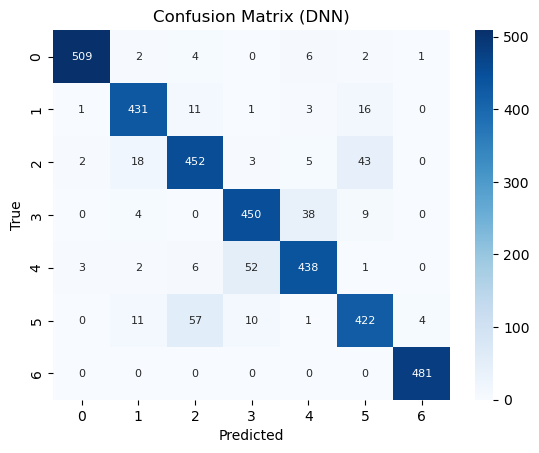

In [22]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 8}, cmap='Blues')
plt.title("Confusion Matrix (DNN)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [23]:
y_test_labels = np.argmax(y_test_cat, axis=1)

print(classification_report(y_test_labels, y_pred, digits=4))

              precision    recall  f1-score   support

           1     0.9883    0.9714    0.9798       524
           2     0.9209    0.9309    0.9259       463
           3     0.8528    0.8642    0.8585       523
           4     0.8721    0.8982    0.8850       501
           5     0.8921    0.8725    0.8822       502
           6     0.8560    0.8356    0.8457       505
           7     0.9897    1.0000    0.9948       481

    accuracy                         0.9097      3499
   macro avg     0.9103    0.9104    0.9103      3499
weighted avg     0.9098    0.9097    0.9097      3499



In [24]:
# Metrics
f1 = f1_score(y_test_labels, y_pred, average='macro')  # or 'weighted' if classes are imbalanced
conf_matrix = confusion_matrix(y_test_labels, y_pred)
accuracy = accuracy_score(y_test_labels, y_pred)

# Precision and Recall
precision = precision_score(y_test_labels, y_pred, average='macro')  # 'micro' or 'weighted' as needed
recall = recall_score(y_test_labels, y_pred, average='macro')

# Print results
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

F1 Score: 0.910260808254977
Confusion Matrix:
 [[509   2   4   0   6   2   1]
 [  1 431  11   1   3  16   0]
 [  2  18 452   3   5  43   0]
 [  0   4   0 450  38   9   0]
 [  3   2   6  52 438   1   0]
 [  0  11  57  10   1 422   4]
 [  0   0   0   0   0   0 481]]
Accuracy: 0.9096884824235496
Precision: 0.9102808044129667
Recall: 0.9104087763090242


In [32]:
nn_model.save("my_model.h5")


In [29]:
import joblib
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [7]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

# Suppose your dataset looks like this:
# columns = ["ch1", "ch2", ..., "ch8", "class", "label"]
# where "label" = subject ID, "class" = gesture

# Load your data (if CSV)
df = pd.read_csv("D:\Project\AI_ML_Projects\EMG Classification\dataset\EMG-data.csv")

df_clean = df[df["class"] != 0].copy()

X = df_clean.drop(columns=["class", "label"])  # EMG signals (features)
y = df_clean["class"]                          # Gesture labels
groups = df_clean["label"]                     # Subject IDs

# Split so that no subject overlaps between train and test
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in gss.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    train_groups, test_groups = groups.iloc[train_idx], groups.iloc[test_idx]

print("Train subjects:", train_groups.unique())
print("Test subjects:", test_groups.unique())

Train subjects: [ 1  2  3  4  5  6  7  8  9 10 11 12 15 16 18 19 20 21 23 24 25 26 28 29
 30 33 34 35]
Test subjects: [13 14 17 22 27 31 32 36]


In [17]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

# Example dataframe structure
# df columns = ["ch1", ..., "ch8", "class", "label"]

X = df_clean.drop(columns=["class", "label","time"])   # features
y = df_clean["class"]                           # target = gesture
# Create group identifier (subject_gesture)
df_clean["sample_id"] = df_clean[["label", "class"]].astype(str).agg("_".join, axis=1)

# Split while keeping samples intact
groups = df_clean["sample_id"]
# groups = unique identifier like "Person1_Gesture2"

# Split while keeping each (label, class) group together
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in gss.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print("Unique (subject, gesture) pairs in train:", groups.iloc[train_idx].unique())
print("Unique (subject, gesture) pairs in test:", groups.iloc[test_idx].unique())

Unique (subject, gesture) pairs in train: ['1_1' '1_2' '1_3' '1_4' '1_5' '2_1' '2_2' '2_3' '2_4' '2_5' '2_6' '3_4'
 '3_5' '3_6' '4_1' '4_2' '4_3' '4_5' '4_6' '5_1' '5_3' '5_4' '5_6' '6_2'
 '6_3' '6_4' '6_5' '6_6' '7_1' '7_2' '7_3' '7_5' '7_6' '8_1' '8_3' '8_4'
 '8_5' '9_1' '9_3' '9_5' '9_6' '10_1' '10_2' '10_3' '10_4' '10_5' '10_6'
 '11_1' '11_2' '11_3' '11_5' '11_6' '11_7' '12_1' '12_2' '12_5' '13_1'
 '13_2' '13_3' '13_5' '13_4' '13_6' '14_2' '14_3' '14_4' '14_5' '15_1'
 '15_2' '15_3' '15_4' '15_5' '15_6' '16_1' '16_2' '16_3' '16_4' '16_5'
 '16_6' '17_1' '17_2' '17_4' '17_5' '17_6' '18_1' '18_2' '18_3' '18_4'
 '18_5' '18_6' '19_2' '19_3' '19_4' '19_5' '19_6' '20_2' '20_3' '20_4'
 '20_5' '20_6' '21_2' '21_4' '21_5' '21_6' '22_2' '22_3' '22_4' '22_5'
 '22_6' '23_1' '23_2' '23_3' '23_4' '23_5' '23_6' '24_1' '24_2' '24_4'
 '24_5' '25_1' '25_2' '25_3' '25_5' '25_6' '26_1' '26_2' '26_3' '26_4'
 '26_5' '27_2' '27_3' '27_4' '27_6' '28_1' '28_2' '28_3' '28_6' '29_1'
 '29_2' '29_3' '29_4' '29_5

In [19]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1512750 entries, 2287 to 4237211
Data columns (total 9 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   channel1   1512750 non-null  float64
 1   channel2   1512750 non-null  float64
 2   channel3   1512750 non-null  float64
 3   channel4   1512750 non-null  float64
 4   channel5   1512750 non-null  float64
 5   channel6   1512750 non-null  float64
 6   channel7   1512750 non-null  float64
 7   channel8   1512750 non-null  float64
 8   sample_id  1512750 non-null  object 
dtypes: float64(8), object(1)
memory usage: 115.4+ MB


In [ ]:
for train_idx, test_idx in gss.split(X, y, groups):
    train_df = df_clean.iloc[train_idx].copy()
    test_df  = df_clean.iloc[test_idx].copy()

# Count number of rows per sample in TRAIN
train_sample_sizes = train_df.groupby("sample_id").size()

# Count number of rows per sample in TEST
test_sample_sizes = test_df.groupby("sample_id").size()

print("Row count of each sample in Train:\n", train_sample_sizes)
print("\nRow count of each sample in Test:\n", test_sample_sizes)

Row count of each sample in Train:
 sample_id
10_1    7690
10_2    6571
10_3    6534
10_4    6766
10_5    6658
        ... 
8_5     6237
9_1     7083
9_3     5838
9_5     6050
9_6     6474
Length: 174, dtype: int64

Row count of each sample in Test:
 sample_id
11_4    7138
12_3    7350
12_4    7242
12_6    7521
14_1    6670
14_6    6452
17_3    6709
19_1    6258
1_6     7143
20_1    7938
21_1    6285
21_3    6820
22_1    6133
24_3    6744
24_6    7371
25_4    6365
26_6    6217
27_1    7167
27_5    7405
28_4    5733
28_5    5245
30_4    7061
30_7    6591
31_1    6924
31_4    6180
32_2    8085
33_1    7082
33_3    6127
33_4    6527
34_5    7710
36_1    6391
36_4    5926
3_1     6443
3_2     6301
3_3     6486
4_4     7193
5_2     6806
5_5     6098
6_1     5814
7_4     8923
8_2     6537
8_6     6476
9_2     6019
9_4     5776
dtype: int64


In [20]:
import numpy as np

# Group each sample by (label, class)
samples = []
labels = []   # gesture labels (y)
subjects = [] # person IDs (optional)

for (person, gesture), group in df_clean.groupby(["label", "class"]):
    X_sample = group.drop(columns=["label", "class","time","sample_id"]).values  # shape = (timesteps, 8)
    samples.append(X_sample)
    labels.append(gesture)
    subjects.append(person)

print("Number of samples:", len(samples))
print("Shape of first sample:", samples[0].shape)


Number of samples: 218
Shape of first sample: (7311, 8)


In [16]:
samples

[array([[-1e-05, 0.0, -1e-05, ..., -1e-05, 1e-05, '1_1'],
        [-1e-05, -2e-05, 0.0, ..., -3e-05, -2e-05, '1_1'],
        [-1e-05, -2e-05, 0.0, ..., -3e-05, -2e-05, '1_1'],
        ...,
        [-1e-05, -1e-05, -3e-05, ..., -1e-05, 0.0, '1_1'],
        [-1e-05, -1e-05, -3e-05, ..., -1e-05, 0.0, '1_1'],
        [1e-05, 3e-05, 4e-05, ..., -1e-05, 2e-05, '1_1']], dtype=object),
 array([[-0.00011, -2e-05, -7e-05, ..., -0.00036, -1e-05, '1_2'],
        [0.00014, 1e-05, 0.00021, ..., -0.00021, 6e-05, '1_2'],
        [0.00014, 1e-05, 0.00021, ..., -0.00021, 6e-05, '1_2'],
        ...,
        [-6e-05, -6e-05, 2e-05, ..., -7e-05, -3e-05, '1_2'],
        [-6e-05, -6e-05, 2e-05, ..., -7e-05, -3e-05, '1_2'],
        [-6e-05, -6e-05, 2e-05, ..., -7e-05, -3e-05, '1_2']], dtype=object),
 array([[-0.00012, -0.00014, 8e-05, ..., 6e-05, -7e-05, '1_3'],
        [-0.00012, -0.00014, 8e-05, ..., 6e-05, -7e-05, '1_3'],
        [-0.00012, -0.00014, 8e-05, ..., 6e-05, -7e-05, '1_3'],
        ...,
        

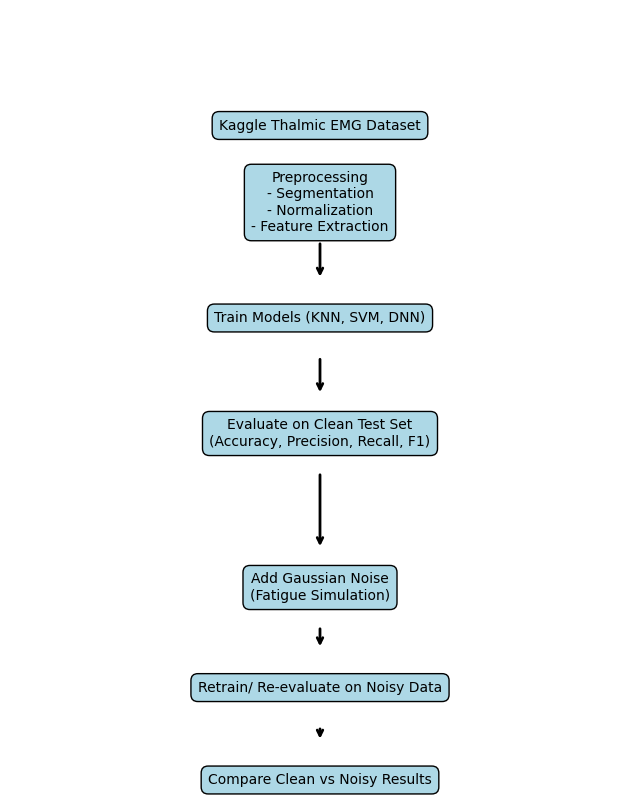

In [11]:
import matplotlib.pyplot as plt

# Define boxes (nodes)
boxes = {
    "data": "Kaggle Thalmic EMG Dataset",
    "prep": "Preprocessing\n- Segmentation\n- Normalization\n- Feature Extraction",
    "train": "Train Models (KNN, SVM, DNN)",
    "eval": "Evaluate on Clean Test Set\n(Accuracy, Precision, Recall, F1)",
    "noise": "Add Gaussian Noise\n(Fatigue Simulation)",
    "retest": "Retrain/ Re-evaluate on Noisy Data",
    "compare": "Compare Clean vs Noisy Results"
}

# Y positions for vertical layout (top to bottom)
y_positions = [0.85, 0.75, 0.6, 0.45, 0.25, 0.12, 0.0]

fig, ax = plt.subplots(figsize=(8, 10))
ax.axis('off')

# Draw boxes
for (y, key) in zip(y_positions, boxes.keys()):
    ax.text(0.5, y, boxes[key], ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.5", fc="lightblue", ec="black"))

# Draw arrows top → bottom
for i in range(len(y_positions)-1):
    ax.annotate("", xy=(0.5, y_positions[i+1]+0.05), xytext=(0.5, y_positions[i]-0.05),
                arrowprops=dict(arrowstyle="->", lw=2))


plt.show()
